In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import warnings
warnings.filterwarnings("ignore") 


sales = pd.read_parquet('GazProm/sales.parquet')
effect = pd.read_parquet('GazProm/effect.parquet')
drinks = pd.read_parquet('GazProm/drinks.parquet')
daily_volume = pd.read_parquet('GazProm/daily_volume.parquet')
attack_probability = pd.read_parquet('GazProm/attack_probability.parquet')
promo = pd.read_parquet('GazProm/promo.parquet')

In [2]:
drinks = drinks.rename(columns={'Напиток': 'product', 'Тип': 'type'})
df = daily_volume.copy()
df = df.merge(drinks, on='product')

In [3]:
def HandleMissingValues(df):
    num_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]
    cat_cols = [cname for cname in df.columns if df[cname].dtype == "object"]
    values = {}
    for a in cat_cols:
        values[a] = 'UNKNOWN'
        
    for a in num_cols:
        values[a] = df[a].median()
        
    df.fillna(value=values, inplace=True)

In [4]:
def get_effect_drinks_type(drink):
    if drink in ['Вода', 'Безалкогольное']:
        return 'Безалкогольный'
    else:
        return 'Алкогольный'

    
effect['type'] = effect['product'].apply(lambda x: get_effect_drinks_type(x))
effect_new = effect.copy()
df_w_eff = df.merge(effect_new, on=['date', 'city', 'product', 'type'], how='inner')
df_w_eff = df_w_eff.drop(columns=['id'])
# df_w_eff.head(3)

In [5]:
promo['date_arange'] = promo.apply(
        lambda x: pd.date_range(start=x['Начало'], end=x['Конец']).strftime("%Y-%m-%d").to_numpy(),
        axis=1
)
HandleMissingValues(promo)
promo_dates = pd.DataFrame()
for i in range(len(promo)):
    promo_new = pd.DataFrame()
    promo_new['date'] = promo['date_arange'][i]
    promo_new['promo_name'] = promo['Название'][i]
    promo_new['Кромер'] = promo['Кромер'][i]
    promo_new['Париж'] = promo['Париж'][i]
    promo_new['Бат'] = promo['Бат'][i]
    promo_new['Лондон'] = promo['Лондон'][i]
    promo_new['Салем'] = promo['Салем'][i]
    promo_new['Коукворт'] = promo['Коукворт'][i]
    promo_new['Авимор'] = promo['Авимор'][i]
    promo_new['Даффтаун'] = promo['Даффтаун'][i]
    promo_new['Абердин'] = promo['Абердин'][i]
    promo_new['Нью-Йорк'] = promo['Нью-Йорк'][i]
    promo_new['Литтл Уингинг'] = promo['Литтл Уингинг'][i]
    promo_new['Алкогольное'] = promo['Алкогольное'][i]
    promo_new['Безалкогольное'] = promo['Безалкогольное'][i]
    promo_new['Затраты на акцию, галлеонов'] = promo['Затраты на акцию, галлеонов'][i]
    promo_dates = pd.concat([promo_new, promo_dates])
    
promo_dates.index = range(len(promo_dates))
# promo_dates.head(5)

In [6]:
cts_list = ['Кромер', 'Париж', 'Бат', 'Лондон', 'Салем',
       'Коукворт', 'Авимор', 'Даффтаун', 'Абердин', 'Нью-Йорк',
       'Литтл Уингинг']
for city in cts_list:
    promo_dates[city] = promo_dates[city].apply(lambda x: city if x == 1.0 else 0)

new_promo = pd.DataFrame()
for city in cts_list:
    new_city_df = pd.DataFrame()
    new_city_df = promo_dates[['date', 'promo_name', 'Алкогольное', 'Безалкогольное', 'Затраты на акцию, галлеонов']]
    new_city_df['city'] = promo_dates[city]
    new_city_df = new_city_df[new_city_df['city'] != 0]
    new_promo = pd.concat([new_promo, new_city_df])
    
new_promo.index = range(len(new_promo))    

In [7]:
assert promo_dates.date.nunique() ==  new_promo.date.nunique()

In [8]:
final_data = pd.merge(df_w_eff, new_promo, left_on=['city', 'date'], right_on=['city', 'date'], how="inner")

In [15]:
def find_depends(row):
    if row.type == 'Алкогольный' and row['Алкогольное'] == 1.0:
        return 1
    if row.type == 'Безалкогольный' and row['Безалкогольное'] == 1.0:
        return 1
    return 0


final_data['depends'] = final_data.apply(lambda x: find_depends(x), axis=1)
final_data_only_with_depends = final_data[final_data['depends'] == 1]
final_data_only_with_depends_grouped = final_data_only_with_depends.groupby(['promo_name', 'type']).aggregate({'volume_litr_x': 'sum', 'volume_litr_y': 'sum'}).reset_index()
final_data_only_with_depends_grouped['x_y'] = final_data_only_with_depends_grouped['volume_litr_y'] + final_data_only_with_depends_grouped['volume_litr_x']
final_data_only_with_depends_grouped['prercent_plus'] = (final_data_only_with_depends_grouped['volume_litr_y']/final_data_only_with_depends_grouped['volume_litr_x'])*100
final_data_only_with_depends_grouped = final_data_only_with_depends_grouped.sort_values('prercent_plus')

In [16]:
final_data_only_with_depends_grouped

,promo_name,type,volume_litr_x,volume_litr_y,x_y,prercent_plus
15,Конфетки за метки,Алкогольный,9.468741e+05,1.767802e-01,9.468743e+05,0.000019
13,Двойная сладость,Алкогольный,5.979072e+06,1.610804e+00,5.979074e+06,0.000027
6,Акция при поимке Пикси от 15 литров напитков,Алкогольный,2.390457e+06,6.658200e-01,2.390458e+06,0.000028
34,С литрушки на лягушку 16 литров,Алкогольный,5.745520e+06,7.952002e+00,5.745528e+06,0.000138
17,"Лучше золотой снитч в руках, чем гиппогриф в небе",Алкогольный,5.198950e+06,7.200566e+00,5.198957e+06,0.000139
36,Сладкий бизнес декабрь 1997,Алкогольный,2.905576e+06,4.129033e+00,2.905580e+06,0.000142
37,Сладкий бизнес и лягушка + 15 литров напитков,Алкогольный,5.270774e+06,7.745918e+00,5.270782e+06,0.000147
3,Back to Hogwarts,Алкогольный,2.704712e+06,4.480650e+00,2.704717e+06,0.000166
35,Скидка на Огненный виски 3 кната если на барме...,Алкогольный,1.202965e+06,2.212680e+00,1.202967e+06,0.000184
5,Скидка на Сливочное пиво 2 кната если на барм...,Алкогольный,1.074238e+06,1.998587e+00,1.074240e+06,0.000186


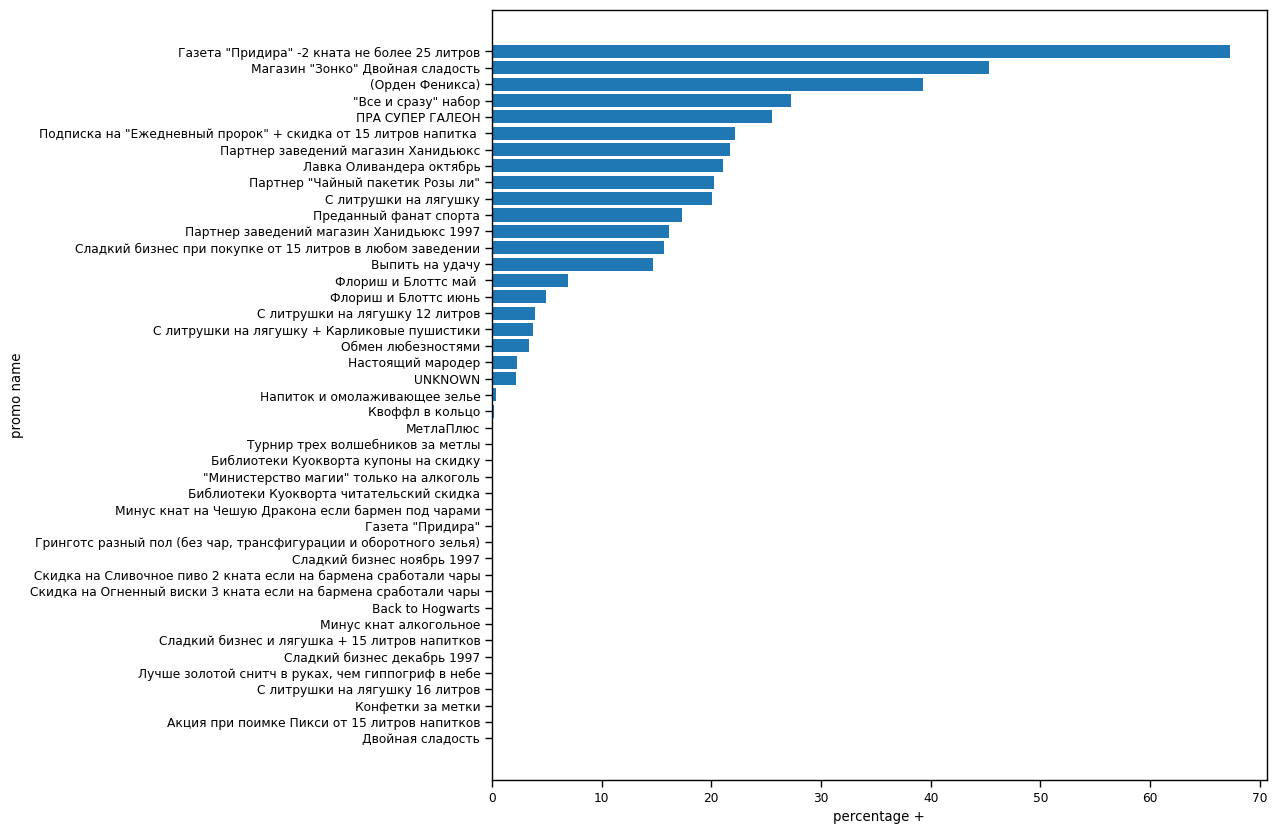

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10


sns.set_context('paper')
plt.barh(final_data_only_with_depends_grouped['promo_name'], final_data_only_with_depends_grouped["prercent_plus"])
plt.xlabel("percentage +")
plt.ylabel("promo name")
plt.show()

Text(0.5, 0, 'blue - promo; red - main')

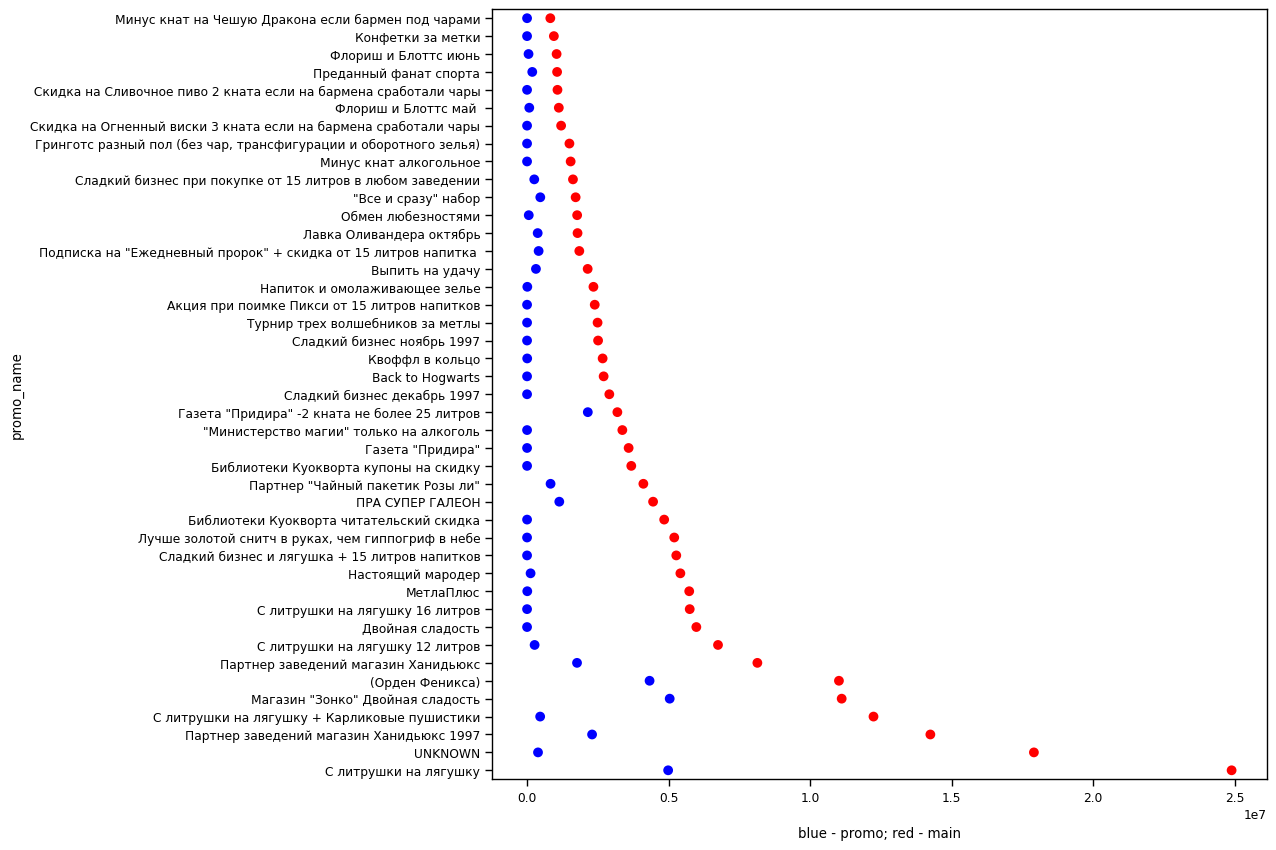

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
main = sns.pointplot(data=final_data_only_with_depends_grouped.sort_values("volume_litr_x"), x="volume_litr_x", y="promo_name", orient="h", join=False, color="red")
promo = sns.pointplot(data=final_data_only_with_depends_grouped.sort_values("volume_litr_x"), x="volume_litr_y", y="promo_name", orient="h", join=False, color="blue")
ax.set_xlabel('blue - promo; red - main', labelpad=16)

In [12]:
final_data_only_with_depends_grouped.to_csv('GazProm/submission1.csv')